# ФИЛЬТРАЦИЯ ШУМОВ НА ИЗОБРАЖЕНИЯХ
## Петров Попов 6411

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage import img_as_float
from skimage import exposure
from scipy import signal


from skimage.util import random_noise
from scipy.signal import convolve2d
from scipy.ndimage import median_filter
from skimage.io import imread, imshow, show
#import cv2
from skimage.metrics import normalized_root_mse
import warnings
warnings.filterwarnings('ignore')

variance = lambda image: np.mean(image ** 2) - (np.mean(image)) ** 2
variance_error =lambda image,recover_image: ((np.sum(recover_image) - np.sum(image)) ** 2) / (image.shape[0]*image.shape[1])
def plot_img(image, ax):
    """Plot an image along with its histogram and cumulative histogram.

    """
    # Преобразование изображения в формат с плавающей запятой двойной точности
    #image = img_as_float(image)

    # Display image
    ax.imshow(image, cmap='gray')

    return ax

### Исходное шахматное поле

D = 0.015747789311803206


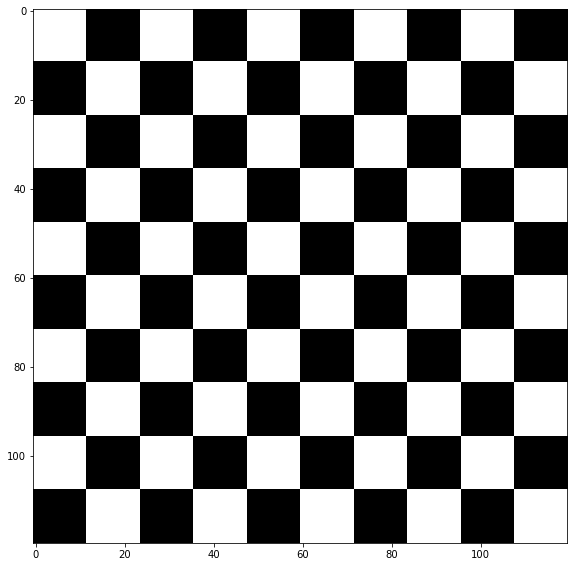

In [10]:
# сколько пикселей занимает доска по x и y
M = 128
N = 128
# сколько пикселей занимает один квадрат доски
cell = 12
# яркости 
f, s = 160/255, 96/255
def draw_board(w, h, cell, f, s):
    # определяем построчно яркости полей
    board = [[f, s] * int(w / cell / 2), [s, f] * int(w / cell / 2)] * int(h / cell / 2)
    # формируем матрицу, где цветами, выбранными на шаге выше закрашиваются поля доски 
    # * np.kron - Вычисляет произведение Кронекера, составной массив, состоящий из блоков второго массива, масштабированных первым.
    board = np.kron(board, np.ones((cell, cell)))
    return board

img = draw_board(M, N, cell, f, s)

# Вычисляем дисперсию доски
dispersion=variance(img)
print(f"D = {dispersion}")


fig = plt.figure(figsize=(8, 8))
axes=np.zeros((1,1),dtype=object)
axes[0][0]=fig.add_subplot(111)


ax_img=plot_img(img,axes[0][0])


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

###  Четыре шума:
- два белых       (сигнал/шум = 1 и 10)
- два импульсных  (вероятности 0.1 и 0.3)

Белый шум (сигнал/шум = 1)  D = 0.015915183739047316
Белый шум (сигнал/шум = 10)  D = 0.00157839812948155
Импульсный шум (вероятность 0.1)  D = 0.09914691357838254
Импульсный шум (вероятность 0.3)  D = 0.3009601658939315


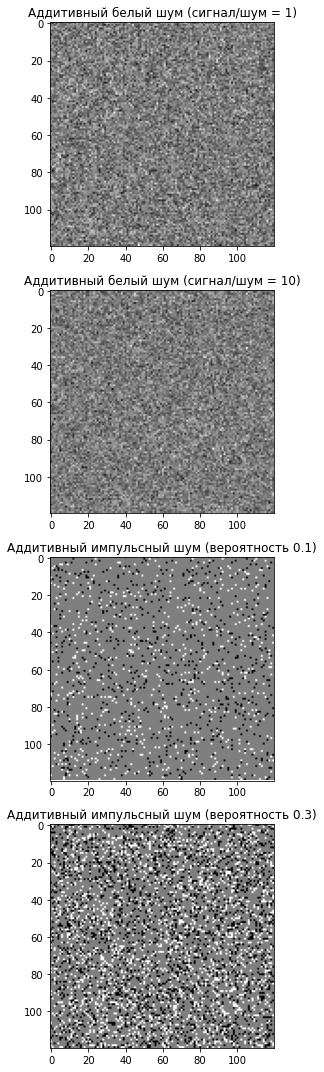

In [3]:
# Аддитивный белый шум (сигнал/шум = 1)
noise_img_1 = random_noise(img.copy(), var=dispersion / 1)
noise_1 = img - noise_img_1

# Аддитивный белый шум (сигнал/шум = 10)
noise_img_10 = random_noise(img.copy(), var=dispersion / 10)
noise_10 = img - noise_img_10

# Аддитивный импульсный шум (вероятность 0.1)

noise_0_1 = random_noise(np.full(img.shape, -1), mode='s&p', amount=0.1)
noise_img_0_1=np.where((noise_0_1 ==0) | (noise_0_1 ==1),noise_0_1, img)


# Аддитивный импульсный шум (вероятность 0.3)
noise_0_3 = random_noise(np.full(img.shape, -1), mode='s&p', amount=0.3)
noise_img_0_3=np.where((noise_0_3 ==0) | (noise_0_3 ==1),noise_0_3, img)




fig = plt.figure(figsize=(15, 15))
axes=np.zeros((4,1),dtype=object)
axes[0,0]=fig.add_subplot(411)
axes[1,0]=fig.add_subplot(412)
axes[2,0]=fig.add_subplot(413)
axes[3,0]=fig.add_subplot(414)

print(f"Белый шум (сигнал/шум = 1)  D = {variance(noise_1)}")
print(f"Белый шум (сигнал/шум = 10)  D = {variance(noise_10)}")
print(f"Импульсный шум (вероятность 0.1)  D = {variance(noise_0_1)}")
print(f"Импульсный шум (вероятность 0.3)  D = {variance(noise_0_3)}")


ax_img=plot_img(noise_1,axes[0,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 1)")
ax_img=plot_img(noise_10,axes[1,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 10)")
ax_img=plot_img(noise_0_1,axes[2,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.1)")
ax_img=plot_img(noise_0_3,axes[3,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.3)")

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### Четыре зашумленных изображения

Белый шум (сигнал/шум = 1)  D_error = 0.00019176867824723852
Белый шум (сигнал/шум = 10)  D_error = 6.016467325735839e-05
Импульсный шум (вероятность 0.1)  D_error = 7.8235380622837525
Импульсный шум (вероятность 0.3)  D_error = 78.77200584817818


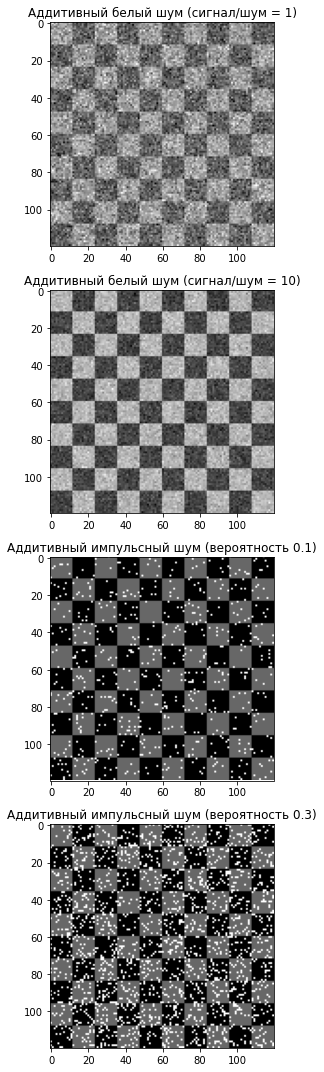

In [4]:
fig = plt.figure(figsize=(15, 15))
axes=np.zeros((4,1),dtype=object)
axes[0,0]=fig.add_subplot(411)
axes[1,0]=fig.add_subplot(412)
axes[2,0]=fig.add_subplot(413)
axes[3,0]=fig.add_subplot(414)


print(f"Белый шум (сигнал/шум = 1)  D_error = {variance_error(img,noise_img_1)}")
print(f"Белый шум (сигнал/шум = 10)  D_error = {variance_error(img,noise_img_10)}")
print(f"Импульсный шум (вероятность 0.1)  D_error = {variance_error(img,noise_img_0_1)}")
print(f"Импульсный шум (вероятность 0.3)  D_error = {variance_error(img,noise_img_0_3)}")


ax_img=plot_img(noise_img_1,axes[0,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 1)")
ax_img=plot_img(noise_img_10,axes[1,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 10)")
ax_img=plot_img(noise_img_0_1,axes[2,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.1)")
ax_img=plot_img(noise_img_0_3,axes[3,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.3)")

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### Медианный фильтр

In [5]:
def median_filter_and_metrics(img,noise_img):
    # Медианный фильтр
    median_img = median_filter(noise_img, size=3)
    median_v = variance_error(img,median_img)
    median_ksh = np.mean((median_img - img) ** 2) / np.mean((noise_img - img) ** 2)
    return median_img,median_v,median_ksh


(белый шум (сигнал/шум = 1)) D :  0.015181807931966718
(белый шум (сигнал/шум = 1)) D_error:  0.0011496001264109518
(белый шум (сигнал/шум = 1)) Коеффициент снижения шума:  0.27786532921838747

(белый шум (сигнал/шум = 10)) D :  0.014328599269349485
(белый шум (сигнал/шум = 10)) D_error:  0.0007340187552548787
(белый шум (сигнал/шум = 10)) Коеффициент снижения шума:  0.334864136607635

(импульсный шум (вероятность 0.1)) D :  0.015778205846457505
(импульсный шум (вероятность 0.1)) D_error:  0.026592443077447438
(импульсный шум (вероятность 0.1)) Коеффициент снижения шума:  0.030561493235416255

(импульсный шум (вероятность 0.3)) D:  0.016792526458173196
(импульсный шум (вероятность 0.3)) D_error:  1.9133398788927338
(импульсный шум (вероятность 0.3)) Коеффициент снижения шума:  0.09211092823308024


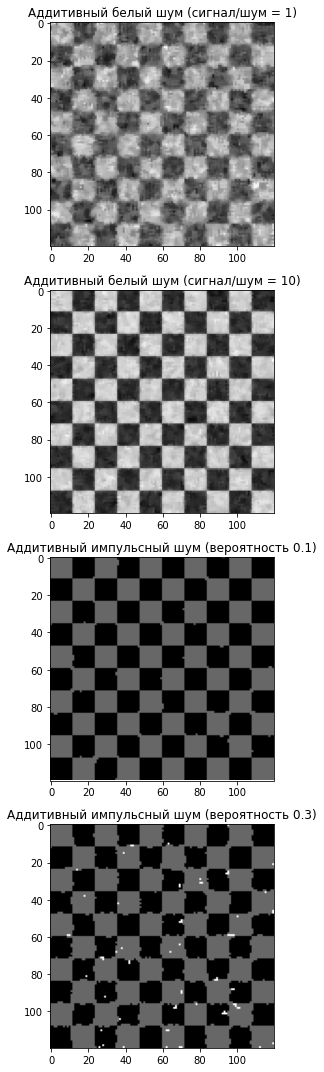

In [6]:
fig = plt.figure(figsize=(15, 15))
axes=np.zeros((4,1),dtype=object)
axes[0,0]=fig.add_subplot(411)
axes[1,0]=fig.add_subplot(412)
axes[2,0]=fig.add_subplot(413)
axes[3,0]=fig.add_subplot(414)

median_recover_img_1,median_sko_img_1,median_ksh_img_1=median_filter_and_metrics(img,noise_img_1)
median_recover_img_10,median_sko_img_10,median_ksh_img_10=median_filter_and_metrics(img,noise_img_10)
median_recover_img_0_1,median_sko_img_0_1,median_ksh_img_0_1=median_filter_and_metrics(img,noise_img_0_1)
median_recover_img_0_3,median_sko_img_0_3,median_ksh_img_0_3=median_filter_and_metrics(img,noise_img_0_3)

print("(белый шум (сигнал/шум = 1)) D : ", variance(median_recover_img_1))
print("(белый шум (сигнал/шум = 1)) D_error: ", median_sko_img_1)
print("(белый шум (сигнал/шум = 1)) Коеффициент снижения шума: ", median_ksh_img_1)
print()
print("(белый шум (сигнал/шум = 10)) D : ",  variance(median_recover_img_10))
print("(белый шум (сигнал/шум = 10)) D_error: ", median_sko_img_10)
print("(белый шум (сигнал/шум = 10)) Коеффициент снижения шума: ", median_ksh_img_10)
print()
print("(импульсный шум (вероятность 0.1)) D : ", variance(median_recover_img_0_1))
print("(импульсный шум (вероятность 0.1)) D_error: ", median_sko_img_0_1)
print("(импульсный шум (вероятность 0.1)) Коеффициент снижения шума: ", median_ksh_img_0_1)
print()
print("(импульсный шум (вероятность 0.3)) D: ",variance(median_recover_img_0_3) )
print("(импульсный шум (вероятность 0.3)) D_error: ", median_sko_img_0_3)
print("(импульсный шум (вероятность 0.3)) Коеффициент снижения шума: ", median_ksh_img_0_3)

ax_img=plot_img(median_recover_img_1,axes[0,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 1)")
ax_img=plot_img(median_recover_img_10,axes[1,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 10)")
ax_img=plot_img(median_recover_img_0_1,axes[2,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.1)")
ax_img=plot_img(median_recover_img_0_3,axes[3,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.3)")

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### Линейный фильтр

In [7]:
def linear_filter_and_metrics(img,noise_img):
    # Линейный сглаживающий фильтр
    mask = np.array([[0.06, 0.1, 0.06], [0.1, 0.36, 0.1], [0.06, 0.1, 0.06]])
    linear_img = convolve2d(noise_img, mask, boundary='symm', mode='same')
    linear_sko = variance_error(img,linear_img)
    linear_ksh = np.mean((linear_img - img) ** 2) / np.mean((noise_img - img) ** 2)
    return linear_img,linear_sko,linear_ksh

(белый шум (сигнал/шум = 1)) D :  0.015743044915759508
(белый шум (сигнал/шум = 1)) D_error:  0.00019176867824723852
(белый шум (сигнал/шум = 1)) Коеффициент снижения шума:  0.24549257823471057

(белый шум (сигнал/шум = 10)) D :  0.01288553951123883
(белый шум (сигнал/шум = 10)) D_error:  6.016467325735839e-05
(белый шум (сигнал/шум = 10)) Коеффициент снижения шума:  0.7645839762017055

(импульсный шум (вероятность 0.1)) D :  0.013924257339378021
(импульсный шум (вероятность 0.1)) D_error:  7.82353806228371
(импульсный шум (вероятность 0.1)) Коеффициент снижения шума:  0.30585705023058585

(импульсный шум (вероятность 0.3)) D:  0.01566026767452927
(импульсный шум (вероятность 0.3)) D_error:  78.77200584817791
(импульсный шум (вероятность 0.3)) Коеффициент снижения шума:  0.3369191481015553


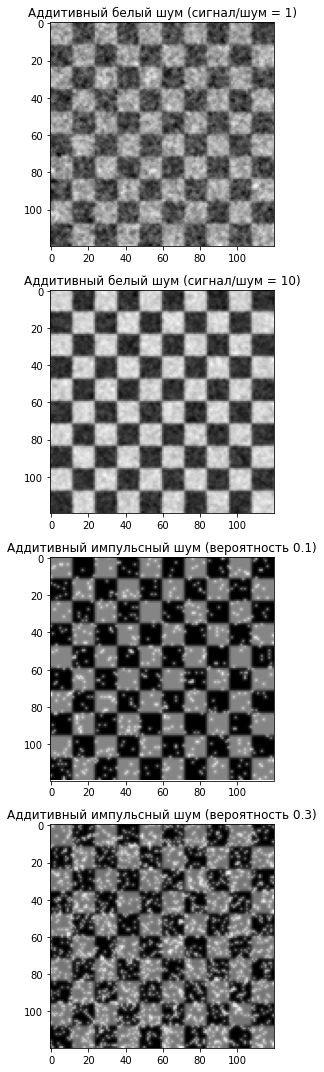

In [8]:
fig = plt.figure(figsize=(15, 15))
axes=np.zeros((4,1),dtype=object)
axes[0,0]=fig.add_subplot(411)
axes[1,0]=fig.add_subplot(412)
axes[2,0]=fig.add_subplot(413)
axes[3,0]=fig.add_subplot(414)

linear_recover_img_1,linear_sko_img_1,linear_ksh_img_1=linear_filter_and_metrics(img,noise_img_1)
linear_recover_img_10,linear_sko_img_10,linear_ksh_img_10=linear_filter_and_metrics(img,noise_img_10)
linear_recover_img_0_1,linear_sko_img_0_1,linear_ksh_img_0_1=linear_filter_and_metrics(img,noise_img_0_1)
linear_recover_img_0_3,linear_sko_img_0_3,linear_ksh_img_0_3=linear_filter_and_metrics(img,noise_img_0_3)

print("(белый шум (сигнал/шум = 1)) D : ", variance(linear_recover_img_1))
print("(белый шум (сигнал/шум = 1)) D_error: ", linear_sko_img_1)
print("(белый шум (сигнал/шум = 1)) Коеффициент снижения шума: ", linear_ksh_img_1)
print()
print("(белый шум (сигнал/шум = 10)) D : ", variance(linear_recover_img_10))
print("(белый шум (сигнал/шум = 10)) D_error: ", linear_sko_img_10)
print("(белый шум (сигнал/шум = 10)) Коеффициент снижения шума: ", linear_ksh_img_10)
print()
print("(импульсный шум (вероятность 0.1)) D : ", variance(linear_recover_img_0_1))
print("(импульсный шум (вероятность 0.1)) D_error: ", linear_sko_img_0_1)
print("(импульсный шум (вероятность 0.1)) Коеффициент снижения шума: ", linear_ksh_img_0_1)
print()
print("(импульсный шум (вероятность 0.3)) D: ", variance(linear_recover_img_0_3))
print("(импульсный шум (вероятность 0.3)) D_error: ", linear_sko_img_0_3)
print("(импульсный шум (вероятность 0.3)) Коеффициент снижения шума: ", linear_ksh_img_0_3)

ax_img=plot_img(linear_recover_img_1,axes[0,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 1)")
ax_img=plot_img(linear_recover_img_10,axes[1,0])
ax_img.set_title("Аддитивный белый шум (сигнал/шум = 10)")
ax_img=plot_img(linear_recover_img_0_1,axes[2,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.1)")
ax_img=plot_img(linear_recover_img_0_3,axes[3,0])
ax_img.set_title("Аддитивный импульсный шум (вероятность 0.3)")

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### Наглядное сравнение двух фильтров

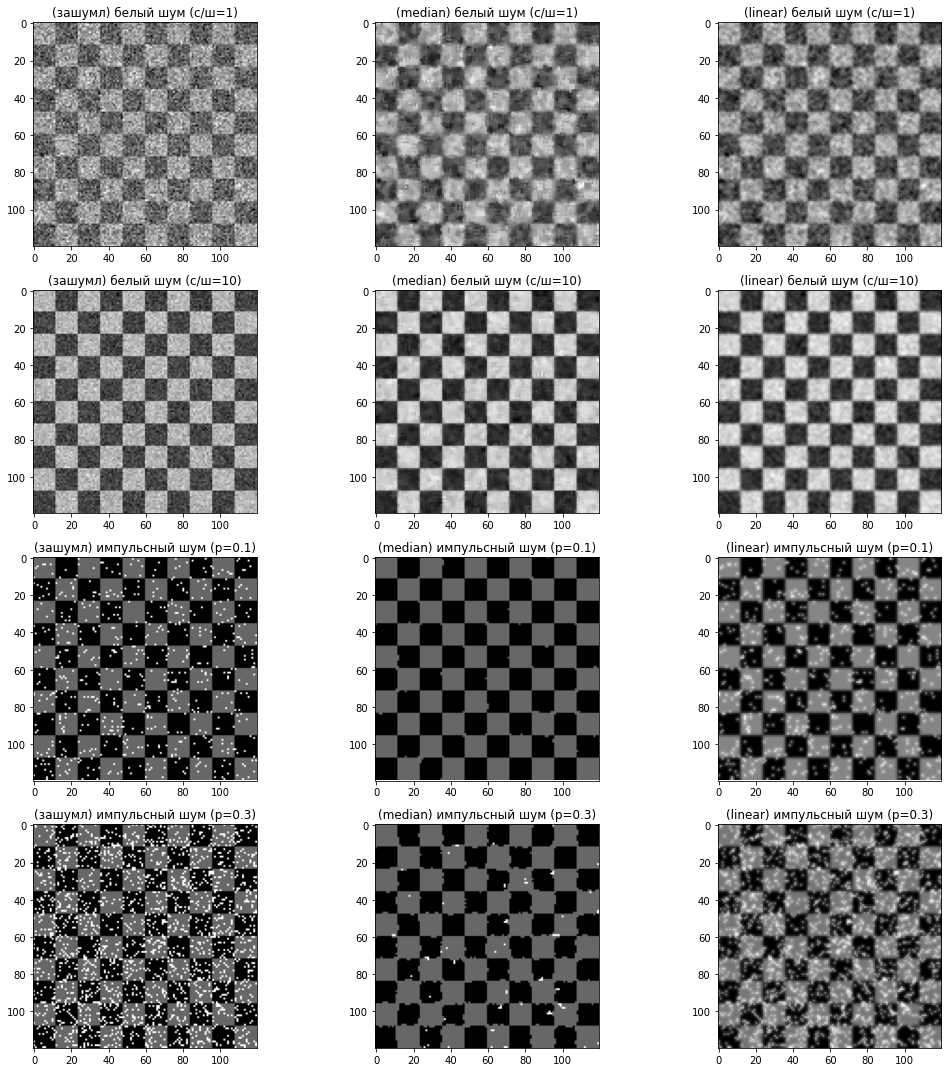

In [9]:
fig = plt.figure(figsize=(15, 15))
axes=np.zeros((4,3),dtype=object)
axes[0,0]=fig.add_subplot(4,3,1)
axes[0,1]=fig.add_subplot(4,3,2)
axes[0,2]=fig.add_subplot(4,3,3)
axes[1,0]=fig.add_subplot(4,3,4)
axes[1,1]=fig.add_subplot(4,3,5)
axes[1,2]=fig.add_subplot(4,3,6)
axes[2,0]=fig.add_subplot(4,3,7)
axes[2,1]=fig.add_subplot(4,3,8)
axes[2,2]=fig.add_subplot(4,3,9)
axes[3,0]=fig.add_subplot(4,3,10)
axes[3,1]=fig.add_subplot(4,3,11)
axes[3,2]=fig.add_subplot(4,3,12)


ax_img=plot_img(noise_img_1,axes[0,0])
ax_img.set_title("(зашумл) белый шум (с/ш=1)")
ax_img=plot_img(noise_img_10,axes[1,0])
ax_img.set_title("(зашумл) белый шум (с/ш=10)")
ax_img=plot_img(noise_img_0_1,axes[2,0])
ax_img.set_title("(зашумл) импульсный шум (p=0.1)")
ax_img=plot_img(noise_img_0_3,axes[3,0])
ax_img.set_title("(зашумл) импульсный шум (p=0.3)")


ax_img=plot_img(median_recover_img_1,axes[0,1])
ax_img.set_title("(median) белый шум (с/ш=1)")
ax_img=plot_img(median_recover_img_10,axes[1,1])
ax_img.set_title("(median) белый шум (с/ш=10)")
ax_img=plot_img(median_recover_img_0_1,axes[2,1])
ax_img.set_title("(median) импульсный шум (p=0.1)")
ax_img=plot_img(median_recover_img_0_3,axes[3,1])
ax_img.set_title("(median) импульсный шум (p=0.3)")


ax_img=plot_img(linear_recover_img_1,axes[0,2])
ax_img.set_title("(linear) белый шум (с/ш=1)")
ax_img=plot_img(linear_recover_img_10,axes[1,2])
ax_img.set_title("(linear) белый шум (с/ш=10)")
ax_img=plot_img(linear_recover_img_0_1,axes[2,2])
ax_img.set_title("(linear) импульсный шум (p=0.1)")
ax_img=plot_img(linear_recover_img_0_3,axes[3,2])
ax_img.set_title("(linear) импульсный шум (p=0.3)")


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

